In [7]:
import warnings
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_auc_score, \
                    matthews_corrcoef, ConfusionMatrixDisplay,f1_score, \
                    accuracy_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn 
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module, Conv1d, Linear, Dropout, MaxPool1d, functional as F, BatchNorm1d, LazyLinear
from torch.optim import Optimizer
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [2]:
warnings.filterwarnings("ignore", category=Warning)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

cuda:0


In [3]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        super(CustomDataset, self).__init__()
        self.data = torch.from_numpy(x).float()
        self.labels = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def get_labels(self):
        return self.labels

    def get_data(self):
        return self.data


def get_th_dataset(x, y):
    """
    assemble a dataset with the given data and labels
    :param x:
    :param y:
    :return:
    """
    _dataset = CustomDataset(x, y)
    return _dataset


def get_dataloader(dataset: Dataset, batch_size):
    """
    assemble a dataloader with the given dataset
    :param dataset:
    :param batch_size:
    :return:
    """
    _dataLoader = DataLoader(dataset=dataset, batch_size=batch_size, pin_memory=True,
                             drop_last=True, shuffle=True)
    return _dataLoader

In [4]:
class ASLSingleLabel(nn.Module):
    '''
    This loss is intended for single-label classification problems
    '''
    def __init__(self, gamma_pos=0, gamma_neg=4, eps: float = 0.1, reduction='mean'):
        super(ASLSingleLabel, self).__init__()

        self.eps = eps
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        self.targets_classes = []
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.reduction = reduction

    def forward(self, inputs, target):
        '''
        "input" dimensions: - (batch_size,number_classes)
        "target" dimensions: - (batch_size)
        '''
        num_classes = inputs.size()[-1]
        log_preds = self.logsoftmax(inputs)
        self.targets_classes = torch.zeros_like(inputs).scatter_(1, target.long().unsqueeze(1), 1)

        # ASL weights
        targets = self.targets_classes
        anti_targets = 1 - targets
        xs_pos = torch.exp(log_preds)
        xs_neg = 1 - xs_pos
        xs_pos = xs_pos * targets
        xs_neg = xs_neg * anti_targets
        asymmetric_w = torch.pow(1 - xs_pos - xs_neg,
                                 self.gamma_pos * targets + self.gamma_neg * anti_targets)
        log_preds = log_preds * asymmetric_w

        if self.eps > 0:  # label smoothing
            self.targets_classes = self.targets_classes.mul(1 - self.eps).add(self.eps / num_classes)

        # loss calculation
        loss = - self.targets_classes.mul(log_preds)

        loss = loss.sum(dim=-1)
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [5]:
class Cnn(Module):
    """
    CNN model
    """
    def __init__(self, kernel_size=3, output_dim=1, input_dim=320, drop_out=0, stride=2, padding=1):
        super(Cnn, self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.drop_out = drop_out
        self.padding = padding

        self.kernel_1 = kernel_size
        self.channel_1 = 32

        self.conv_1 = Conv1d(kernel_size=self.kernel_1, out_channels=self.channel_1, in_channels=1, stride=1, padding=self.padding)
        self.normalizer_1 = BatchNorm1d(self.channel_1)
        self.pooling_1 = MaxPool1d(kernel_size=self.kernel_1, stride=stride)

        self.dropout = Dropout(p=drop_out)
        self.fc1 = LazyLinear(64)
        self.normalizer_2 = BatchNorm1d(64)
        self.fc2 = Linear(64, 2)

    def forward(self, x):
        x = torch.unsqueeze(x, dim=1)  # (batch, embedding_dim) -> (batch, 1, embedding_dim)
        c_1 = self.pooling_1(F.relu(self.normalizer_1(self.conv_1(x))))

        c_2 = torch.flatten(c_1, start_dim=1)
        c_2 = self.dropout(c_2)
        out = F.relu(self.normalizer_2(self.fc1(c_2)))
        out = self.fc2(out)
        out = torch.softmax(out, dim=-1)
        return out

In [6]:
def to_log(epoch: int, loss: float, accuracy, logFile: str, is_append: bool):
    info = str(epoch) + ' ' + str(loss) + ' ' + str(accuracy) + '\n'
    flag = 'a' if is_append else 'w'
    file = open(logFile, flag)  # append mode
    file.write(info)
    file.close()

def scores(y_pred: torch.Tensor, y_test: torch.Tensor):
    predictions = torch.argmax(y_pred, dim=-1).numpy()
    labels = y_test.numpy()
    # labels = th.argmax(y_test, dim=-1).numpy()
    recall = recall_score(y_pred=predictions, y_true=labels, average='binary')
    precision = precision_score(y_pred=predictions, y_true=labels, average='binary')
    f1 = f1_score(y_pred=predictions, y_true=labels, average='binary')
    accuracy = accuracy_score(y_pred=predictions, y_true=labels)
    # auc_score = roc_auc_score(y_score=y_pred.detach().numpy(), y_true=y_test.detach().numpy())
    corr = matthews_corrcoef(y_true=labels, y_pred=predictions)
    balanced_accuracy = balanced_accuracy_score(y_true=labels, y_pred=predictions, )

    report = {
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "accuracy": accuracy,
        # "auc": auc_score,
        'matthews_corrcoef': corr,
        'balanced_accuracy': balanced_accuracy
    }
    return report


def report(model: torch.nn.Module, dataset: CustomDataset):
    _inputs, _labels = dataset.get_data(), dataset.get_labels()
    print(_inputs.size(0))
    predictions = model(_inputs)
    res = scores(predictions, _labels.squeeze())
    print('accuracy ' + str(res["accuracy"]))
    print('precision ' + str(res["precision"]))
    print('f1 ' + str(res["f1"]))
    print('recall ' + str(res["recall"]))
    # print('auc_score ' + str(res["auc"]))
    print('matthews_corrcoef ' + str(res["matthews_corrcoef"]))
    print('balanced_accuracy ' + str(res["balanced_accuracy"]))
    # get_confusion_matrix(predictions, _labels.squeeze())


def train(model: Module, EPOCHS, optimizer: Optimizer, criteria,
           checkpoint, train_set: DataLoader, vali_set: DataLoader, device, LOG_VALIDATION, LOG_TRAIN):
    """
    fine tune the model and save the best model in the checkpoint
    :param LOG_TRAIN:
    :param LOG_VALIDATION:
    :param device:
    :param model: a Cnn or ConvLSTM model
    :param EPOCHS: hyperparameter Epoch
    :param optimizer: pytorch optimizer
    :param criteria: loss function
    :param checkpoint: model checkpoint
    :param train_set: a dataloader
    :param vali_set: a dataloader
    :return: None
    """
    if os.path.exists(LOG_VALIDATION):
        os.remove(LOG_VALIDATION)
    if os.path.exists(LOG_TRAIN):
        os.remove(LOG_TRAIN)
    model = model.to(device)
    min_vali_loss = float("inf")
    for epoch in tqdm(range(EPOCHS)):
        running_loss = 0.0
        train_acc = []
        vali_loss = 0.0
        model.train()
        counter = 0
        for i, (inputs, labels) in enumerate(train_set):
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            # outputs = outputs.squeeze()
            loss = criteria(outputs.float(), labels.float().squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_acc.append(scores(outputs.to("cpu"), labels.to("cpu"))["accuracy"])
            counter = i
        model.eval()
        acc = 0
        for j, (vali_inputs, vali_labels) in enumerate(vali_set):
            vali_labels = vali_labels.to(device)
            vali_inputs = vali_inputs.to(device)
            vali_outputs = model(vali_inputs)
            # vali_outputs = vali_outputs.squeeze()
            acc = scores(vali_outputs.to('cpu'), vali_labels.to('cpu'))["accuracy"]
            vali_loss = criteria(vali_outputs.to(device).float(), vali_labels.to(device).float().squeeze())
            if vali_loss < min_vali_loss:
                min_vali_loss = vali_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }, checkpoint)
        avg_loss = running_loss / counter  # loss per batch
        train_accuracy = sum(train_acc) / len(train_acc)
        print('epoch {} train_loss: {} vali_loss: {} test_acc: {}'
              .format(epoch + 1, f'{avg_loss:5f}', f'{vali_loss:5f}', f'{acc: 5f}'))
        # logs
        to_log(epoch, avg_loss, train_accuracy, LOG_TRAIN, True)
        to_log(epoch, vali_loss.item(), acc, LOG_VALIDATION, True)

In [24]:
checkpoint = os.path.join(os.getcwd(), 'cnn.pt')
train_loss_log = os.path.join(os.getcwd(), "cnn_train_log.txt")
test_loss_log = os.path.join(os.getcwd(), "cnn_validation_log.txt")

plot_range = 10000  # range(1, 10000)
stratify = True
batch_size = 16
lr = 0.0001
epochs = 10
weight_decay = 0

df = pd.read_csv('../data/pharos/esm2_320_dimensions_with_labels.csv') 
X = df.drop(['label', 'UniProt_id'], axis=1)
y = df['label'].apply(lambda x: 0 if x != 1 else x).to_numpy().astype(np.int64)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scalar = MinMaxScaler()
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
X_test, y_test = smote.fit_resample(X_test, y_test)
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)
train_set = get_th_dataset(X_train, y_train)
test_set = get_th_dataset(X_test, y_test)
train_loader = get_dataloader(train_set, batch_size=batch_size)
test_loader = get_dataloader(test_set, batch_size=len(test_set))

In [25]:
model = Cnn(kernel_size=3, output_dim=1, input_dim=320, drop_out=0, stride=2, padding=1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criteria = ASLSingleLabel(gamma_pos=1, gamma_neg=1, eps = 0.1)  # find the best hyperparameter

In [26]:
train(model=model, EPOCHS=epochs, optimizer=optimizer, checkpoint=checkpoint, criteria=criteria,
      train_set=train_loader, vali_set=test_loader, device=device, LOG_VALIDATION=test_loss_log, LOG_TRAIN=train_loss_log)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:04<00:43,  4.82s/it]

epoch 1 train_loss: 0.183452 vali_loss: 0.335045 test_acc:  0.653744


 20%|██        | 2/10 [00:09<00:38,  4.83s/it]

epoch 2 train_loss: 0.147882 vali_loss: 0.282740 test_acc:  0.720300


 30%|███       | 3/10 [00:14<00:34,  4.86s/it]

epoch 3 train_loss: 0.135947 vali_loss: 0.347903 test_acc:  0.650749


 40%|████      | 4/10 [00:19<00:29,  4.89s/it]

epoch 4 train_loss: 0.129843 vali_loss: 0.342845 test_acc:  0.658236


 50%|█████     | 5/10 [00:24<00:24,  4.83s/it]

epoch 5 train_loss: 0.125264 vali_loss: 0.294933 test_acc:  0.711481


 60%|██████    | 6/10 [00:29<00:19,  4.84s/it]

epoch 6 train_loss: 0.121627 vali_loss: 0.336745 test_acc:  0.670050


 70%|███████   | 7/10 [00:33<00:14,  4.83s/it]

epoch 7 train_loss: 0.120103 vali_loss: 0.332635 test_acc:  0.678702


 80%|████████  | 8/10 [00:38<00:09,  4.84s/it]

epoch 8 train_loss: 0.116957 vali_loss: 0.325444 test_acc:  0.680366


 90%|█████████ | 9/10 [00:43<00:04,  4.83s/it]

epoch 9 train_loss: 0.116479 vali_loss: 0.401945 test_acc:  0.593844


100%|██████████| 10/10 [00:48<00:00,  4.83s/it]

epoch 10 train_loss: 0.115408 vali_loss: 0.357052 test_acc:  0.656073


In [27]:
checkpoint = os.path.join(os.getcwd(), 'cnn.pt')
checkpoint = torch.load(checkpoint)
saved_model = Cnn(output_dim=1, input_dim=320, drop_out=0, stride=2)
saved_model.load_state_dict(checkpoint['model_state_dict'])
saved_model.eval()

Cnn(
  (conv_1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (normalizer_1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pooling_1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0, inplace=False)
  (fc1): LazyLinear(in_features=0, out_features=64, bias=True)
  (normalizer_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [28]:
train_set = get_th_dataset(X_train, y_train)
test_set = get_th_dataset(X_test, y_test)
print('train set val')
report(saved_model, train_set)
print('test set val')
report(saved_model, test_set)

train set val
24048
accuracy 0.9627411842980705
precision 0.9327940261356565
f1 0.9639871382636657
recall 0.9973386560212908
matthews_corrcoef 0.92770593362979
balanced_accuracy 0.9627411842980705
test set val
6010
accuracy 0.7202995008319467
precision 0.9036585365853659
f1 0.6381054897739504
recall 0.49317803660565723
matthews_corrcoef 0.49456723677204967
balanced_accuracy 0.7202995008319467


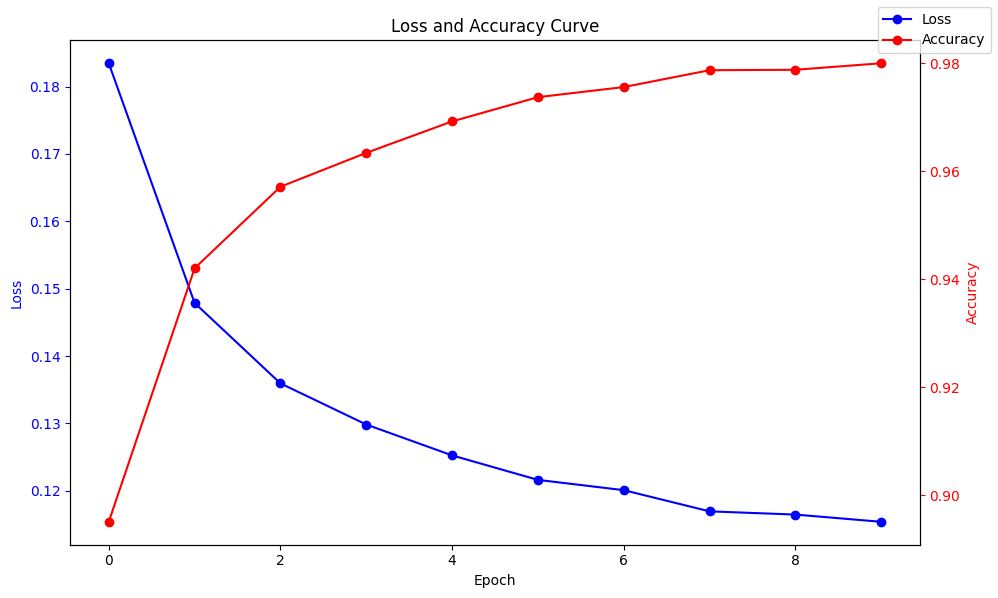

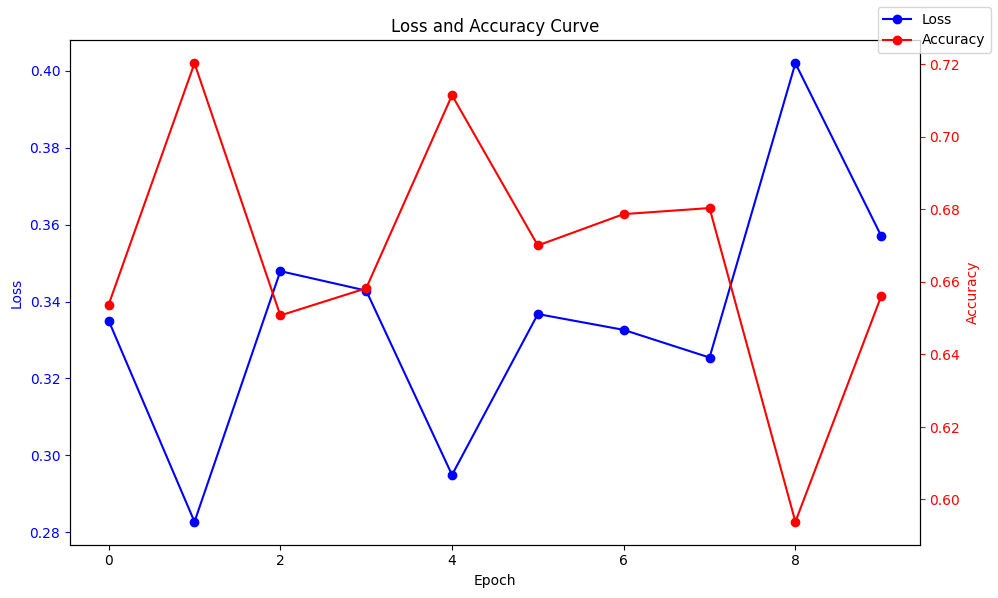

In [29]:
def plot_loss_acc_curve(filename):
    epochs, losses, accs = [], [], []

    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split()
            epoch, loss, acc = int(parts[0]), float(parts[1]), float(parts[2])
            epochs.append(epoch)
            losses.append(loss)
            accs.append(acc)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Loss on the left y-axis
    ax1.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')
    
    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.plot(epochs, accs, marker='o', linestyle='-', color='r', label='Accuracy')
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params('y', colors='r')

    plt.title('Loss and Accuracy Curve')
    fig.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Usage
plot_loss_acc_curve('cnn_train_log.txt')

#because of mini batch reasons, the validation plot is not smooth
plot_loss_acc_curve('cnn_validation_log.txt')